# Python with MongoDB

Helpful learning resources: https://www.tutorialspoint.com/mongodb/index.htm

## Libraries and Settings

In [ ]:
# Libraries
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

from pymongo import MongoClient

# Settings
import warnings
warnings.filterwarnings("ignore")

# Use dark background for plots
plt.style.use('dark_background')

# Current working directory
print(os.getcwd())

/workspace


## Connect to the MongoDB server and list databases

In [2]:
# Connect to the MongoDB server
client = MongoClient("mongodb://mongo:27017/")

# List databases
databases = client.list_database_names()
print("Connected to MongoDB. Databases:", databases)

Connected to MongoDB. Databases: ['admin', 'config', 'local']


## Read and insert data

In [3]:
# Create / Access the specific database and collection
db = client['car_database']
collection = db['car_collection']

# Read data from JSON file
with open('/workspace/car_data.json', 'r') as file:
    example_data = json.load(file)

# Insert data into the collection (similar to tables in an SQL database)
try:
    insert_result = collection.insert_many(example_data)
    print(f"Inserted documents to mongo db")
except Exception as e:
    print(f"Insert error: {e}")


Inserted documents to mongo db


## Define a query with multiple conditions

In [4]:
# Function to query the data
def query_collection(db_name, collection_name, query, client=client):
    if client:
        db = client[db_name]
        collection = db[collection_name]
        results = list(collection.find(query))
        return results
    return []

# Define a query with multiple conditions
query = {
    "Price": {"$gt": 10000, "$lt": 120000},
    "PS": {"$gt": 125},
    "Fuel_Type": {"$eq": 'Benzin'}
}

# Execute the query and fetch the results
results = query_collection('car_database', 'car_collection', query)

# Convert the results into a Pandas DataFrame
df = pd.DataFrame(results)

# Display selected columns
df[['Offer_Id', 'Marke', 'Type', 'Fuel_Type', 'Price', 'PS']].head()

,Offer_Id,Marke,Type,Fuel_Type,Price,PS
0,7512768,MERCEDES-BENZ,MERCEDES-BENZ SLK 200 7G-Tronic (Cabriolet),Benzin,23749,184
1,7512034,MERCEDES-BENZ,MERCEDES-BENZ C 350 Avantgarde 4Matic 7G-Troni...,Benzin,18500,306
2,7512728,MERCEDES-BENZ,MERCEDES-BENZ A 45 AMG 4Matic Speedshift 7G-DC...,Benzin,36000,360
3,7490242,AUDI,AUDI A5 Sportback 2.0 TFSI Sport quattro S-tro...,Benzin,48500,252
4,7512188,MERCEDES-BENZ,MERCEDES-BENZ SLK 200 Kompressor (Cabriolet),Benzin,12000,163


## Create histogram of car prices

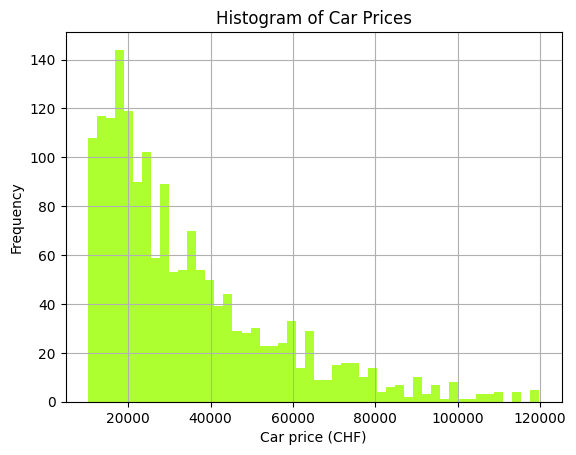

In [5]:
# Create a histogram of car prices
plt.hist(df['Price'], bins=50, color='greenyellow')
plt.title('Histogram of Car Prices')
plt.xlabel('Car price (CHF)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## Define a query to aggregate the data

In [6]:
# Funktion to aggregate data
def aggregate_prices_by_brand(db_name, collection_name, client=client):
    db = client[db_name]
    collection = db[collection_name]
    
    pipeline = [
        {
            "$group": {
                "_id": "$Marke",
                "totalPrice": { "$sum": "$Price" },
                "averagePrice": { "$avg": "$Price" },
                "count": { "$sum": 1 }
            }
        },
        {
            "$sort": { "totalPrice": -1 }
        }
    ]
    
    results = list(collection.aggregate(pipeline))
    return results

# Execute the aggregation query
results = aggregate_prices_by_brand('car_database', 'car_collection')

# Convert the results into a Pandas DataFrame
df = pd.DataFrame(results)

# Rename the '_id' column to 'Marke' for better readability
df.rename(columns={'_id': 'Marke'}, inplace=True)

# Display the DataFrame
df.head()

,Marke,totalPrice,averagePrice,count
0,MERCEDES-BENZ,16532886,33671.865580,491
1,BMW,15535552,28401.374771,547
2,AUDI,14362528,28384.442688,506
3,PORSCHE,13321621,61961.027907,215
4,VW,7145938,18512.792746,386


## Create bar chart of average car prices

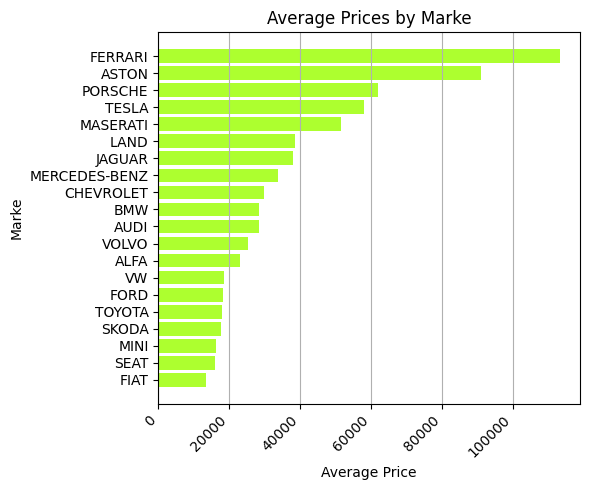

In [7]:
#  Subset with the 20 most important brands in terms of the occurrence of vehicles
df_sub = df.head(20).sort_values(by='averagePrice')

# Create a bar chart
plt.figure(figsize=(6, 5))
plt.barh(df_sub["Marke"], df_sub["averagePrice"], color='greenyellow')
plt.title('Average Prices by Marke')
plt.xlabel('Average Price')
plt.ylabel('Marke')
plt.grid(axis='x')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

## Drop defined collections and databases

In [8]:
# List databases
databases = client.list_database_names()
print("Connected to MongoDB. Databases:", databases)

# Drop defined collections and database if exists
db_name = 'car_database'
collection_name = 'car_collection'
db = client[db_name]
if collection_name in db.list_collection_names():
    db.drop_collection(collection_name)
    print(f"Collection '{collection_name}' dropped from database '{db_name}'.")
else:
    print(f"Collection '{collection_name}' does not exist in database '{db_name}'.")

# Drop the database
if db_name in databases:
    client.drop_database(db_name)
    print(f"Database '{db_name}' dropped.")
else:
    print(f"Database '{db_name}' does not exist.")


Connected to MongoDB. Databases: ['admin', 'car_database', 'config', 'local']
Collection 'car_collection' dropped from database 'car_database'.
Database 'car_database' dropped.


### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [9]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.8.0-1030-azure
Datetime: 2025-08-26 07:03:42
Python Version: 3.11.13
-----------------------------------
